[![Open In Colab](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/badge/open-in-colab.svg)](https://colab.research.google.com/github/crunchdao/crunch-synth/blob/master/crunch_synth/examples/exampletracker.ipynb)

![Banner](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/synth/assets/banner.webp)

# Synth Game

The goal is to anticipate how asset prices will evolve by providing not a single forecasted value, but a **full probability distribution over the future price change at multiple forecast horizons and steps.**

## Probabilistic Forecasting

Probabilistic forecasting provides **a distribution of possible future values** rather than a single point estimate, allowing for uncertainty quantification. Instead of predicting only the most likely outcome, it estimates a range of potential outcomes along with their probabilities by outputting a **probability distribution**.

A probabilistic forecast models the conditional probability distribution of a future value $(Y_t)$ given past observations $(\mathcal{H}_{t-1})$. This can be expressed as:  

$$P(Y_t \mid \mathcal{H}_{t-1})$$

where $(\mathcal{H}_{t-1})$ represents the historical data up to time $(t-1)$. Instead of a single prediction $(\hat{Y}_t)$, the model estimates a full probability distribution $(f(Y_t \mid \mathcal{H}_{t-1}))$, which can take different parametric forms, such as a Gaussian:

$$Y_t \mid \mathcal{H}_{t-1} \sim \mathcal{N}(\mu_t, \sigma_t^2)$$

where $(\mu_t)$ is the predicted mean and $(\sigma_t^2)$ represents the uncertainty in the forecast.

Probabilistic forecasting can be handled through various approaches, including **variance forecasters**, **quantile forecasters**, **interval forecasters** or **distribution forecasters**, each capturing uncertainty differently.

In this notebook, we try to forecast the target location by a gaussian density function (or a mixture), the model output follows the form:

```python
[
    {
        "step": (k + 1) * step,
        "prediction": {
              "density": {
                            "name": "normal",
                            "params": {"loc": y_mean, "scale": y_var}
                          },
              "weight": weight
              }, ...
    }
    for k in range(0, horizon // step)
]
```

A **mixture density**, such as the gaussion mixture $\sum_{i=1}^{K} w_i \mathcal{N}(Y_t | \mu_i, \sigma_i^2)$ allows for capturing multi-modal distributions and approximate more complex distributions.

![proba_forecast_v3](https://github.com/Tarandro/image_broad/blob/main/proba_forecast_v3.png?raw=true)


**Probabilistic Forecasting** is particularly valuable in supply chain management. Below are some interesting resources for a deeper understanding:  

- [Probabilistic Forecasting](https://www.lokad.com/probabilistic-forecasting-definition/) – Overview of probabilistic forecasting and its applications.  
- [Quantile Forecasting](https://www.lokad.com/quantile-regression-time-series-definition/) – Explanation of quantile-based forecasting methods.  
- **Evaluation Metrics:**  
  - [Continuous Ranked Probability Score (CRPS)](https://www.lokad.com/continuous-ranked-probability-score/)  
  - [Cross-Entropy](https://www.lokad.com/cross-entropy-definition/)  
  - [Pinball Loss](https://www.lokad.com/pinball-loss-function-definition/)

## Setup

In [ ]:
# Install required dependencies
%pip install crunch_synth

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm.auto import tqdm
from datetime import datetime, timezone, timedelta

## png render instead of plotly
# import plotly.io as pio
# pio.renderers.default = "png"  
# pio.renderers["png"].width = 1200
# pio.renderers["png"].height = 500

from crunch_synth.price_provider import shared_pricedb
from crunch_synth.tracker import TrackerBase
from crunch_synth.tracker_evaluator import TrackerEvaluator
from crunch_synth.constants import FORECAST_PROFILES, SUPPORTED_ASSETS
from crunch_synth.utils.data import load_test_prices_once, load_initial_price_histories_once, visualize_price_data
from crunch_synth.utils.evaluation_utils import count_evaluations
from crunch_synth.utils.plots import plot_quarantine, plot_prices, plot_scores

## What You Must Predict

Trackers must predict the **probability distribution of price changes**, defined as:

$$
r_{t,k} = P_t - P_{t-k}
$$

For each defined step **$k$** (e.g., 5 minutes, 1 hour, …), your tracker must return a full **probability density function (PDF)** over the future price change **$r_{t,k}$**.

# Gaussian Step Tracker

A simple benchmark that predicts future price changes by assuming they follow a Gaussian (normal) distribution estimated from recent historical data. It models the relative price change over each prediction step.

### **Key Ideas**  

- Historical prices sampled at 5-minute (300s) resolution are converted into returns: $r_{t} = P_t - P_{t-1}$
- The tracker estimates:
    - Drift: mean historical return 𝜇
    - Volatility: standard deviation historical returns 𝜎
- For each future step 𝑘, it outputs a normal density:
$$r_{t,k} \sim \mathcal{N}\!\left(\frac{k}{300}\mu,\; \sqrt{\frac{k}{300}}\sigma\right)$$

> The coefficient $\frac{k}{300}$ represents the ratio of the forecast step length to the base 5-minute (300s) interval, scaling the 5-minute return distribution to the target prediction step.

Each density prediction must comply with the [density_pdf](https://github.com/microprediction/densitypdf/blob/main/densitypdf/__init__.py) specification.

In [3]:
class GaussianStepTracker(TrackerBase):
    """
    An example tracker that models *future incremental returns* as Gaussian-distributed.

    For each forecast step, the tracker returns a normal distribution
    r_{t,step} ~ N(a · mu, √a · sigma) where:
        - mu    = mean historical return
        - sigma = std historical return
        - a = (step / 300) represents the ratio of the forecast step duration to the historical 5-minute return interval.

    Multi-resolution forecasts (5min, 1h, 6h, 24h, ...)
    are automatically handled by `TrackerBase.predict_all()`,
    which calls the `predict()` method once per step size.

    /!/ This is not a price-distribution; it is a distribution over 
    incremental returns between consecutive steps /!/
    """
    def __init__(self):
        super().__init__()

    def predict(self, asset: str, horizon: int, step: int):
        """
        Produce a sequence of incremental return distributions
        for a single (asset, horizon, step) configuration.

        This method is called automatically by `TrackerBase.predict_all()`
        for each step resolution requested by the game.
        """

        # Retrieve recent historical prices (up to 30 days) sampled at 5-minute resolution
        resolution=300 # Use a multiple of 60s because the original data has 60s resolution
        pairs = self.prices.get_prices(asset, days=3, resolution=resolution)
        if not pairs:
            return []

        _, past_prices = zip(*pairs)

        if len(past_prices) < 3:
            return []

        # Compute historical incremental returns (price differences)
        returns = np.diff(past_prices)

        # Estimate drift (mean return) and volatility (std dev of returns)
        mu = float(np.mean(returns))
        sigma = float(np.std(returns))

        if sigma <= 0:
            return []

        num_segments = horizon // step

        # Construct one predictive distribution per future time step.
        # Each distribution models the incremental return over a `step`-second interval.
        #
        # IMPORTANT:
        # - The returned objects must strictly follow the `density_pdf` specification.
        # - Each entry corresponds to the return between t + (k−1)·step and t + k·step.
        #
        # We use a single-component Gaussian mixture for simplicity:
        #   r_{t,k} ~ N( (step / 300) · μ , sqrt(step / 300) · σ )
        #
        # where μ and σ are estimated from historical 5-minute returns.
        distributions = []
        for k in range(1, num_segments + 1):
            distributions.append({
                "step": k * step,                      # Time offset (in seconds) from forecast origin
                "type": "mixture",
                "components": [{
                    "density": {
                        "type": "builtin",             # Note: use 'builtin' distributions instead of 'scipy' for speed
                        "name": "norm",  
                        "params": {
                            "loc": (step/resolution) * mu, 
                            "scale": np.sqrt(step/resolution) * sigma
                            }
                    },
                    "weight": 1                        # Mixture weight — multiple densities with different weights can be combined
                                                       # total components capped for runtime safety to constants.MAX_DISTRIBUTION_COMPONENTS
                }]
            })

        return distributions

## Configurations

In [4]:
##########
# For each asset and historical timestamp, generate density forecasts
# over a fixed forecast horizon (e.g. 24h or 1h) at multiple temporal
# resolutions and evaluate them against realized outcomes.

# Assets to evaluate
assets = ["BTC", "SOL"] # Supported assets: "BTC", "SOL", "ETH", "XAUT", "SPYX", "NVDAX", "TSLAX", "AAPLX", "GOOGLX"
print("Supported assets:", ", ".join(SUPPORTED_ASSETS))
print("Selected assets:", ", ".join(assets))

# Select which forecast profile to evaluate
ACTIVE_HORIZON = "24h"  # options: "24h", "1h"

HORIZON = FORECAST_PROFILES[ACTIVE_HORIZON]["horizon"]
STEPS = FORECAST_PROFILES[ACTIVE_HORIZON]["steps"]
INTERVAL = FORECAST_PROFILES[ACTIVE_HORIZON]["interval"]

# Base directory where all evaluation results will be stored
base_dir_results = "results"
os.makedirs(base_dir_results, exist_ok=True)

# End timestamp for the test data
# evaluation_end: datetime = datetime.now(timezone.utc)
evaluation_end: datetime = datetime(2025, 11, 15, 00, 00, 00, tzinfo=timezone.utc)

# Number of days of test data to load
# Note: the last `horizon` seconds of the time series will not be scored
days = 5

# Number of days of historical data used as warm-up before evaluation.
# This history is used only to initialize the tracker and is not scored.
days_history = 30

Supported assets: BTC, ETH, XAUT, SOL, SPYX, NVDAX, TSLAX, AAPLX, GOOGLX
Selected assets: BTC, SOL


## Data

In [5]:
## Load the last N days of price data (test period)
test_asset_prices = load_test_prices_once(
    assets, shared_pricedb, evaluation_end, days=days
)
# test_asset_prices : dict : {asset -> [(timestamp, price), ...]} used for evaluation.

## Provide the tracker with initial historical data (for the first tick):
## load prices from the last H days up to N days ago
initial_histories = load_initial_price_histories_once(
    assets, shared_pricedb, evaluation_end, days_history=days_history, days_offset=days
)
# initial_histories : dict : {asset -> [(timestamp, price), ...]} used as warm-up history.

Dataset:


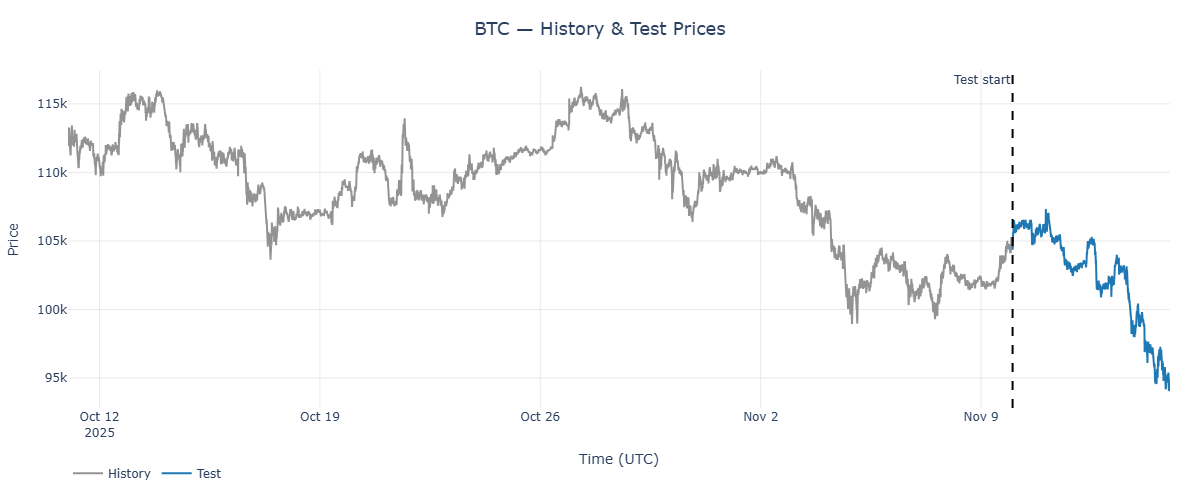

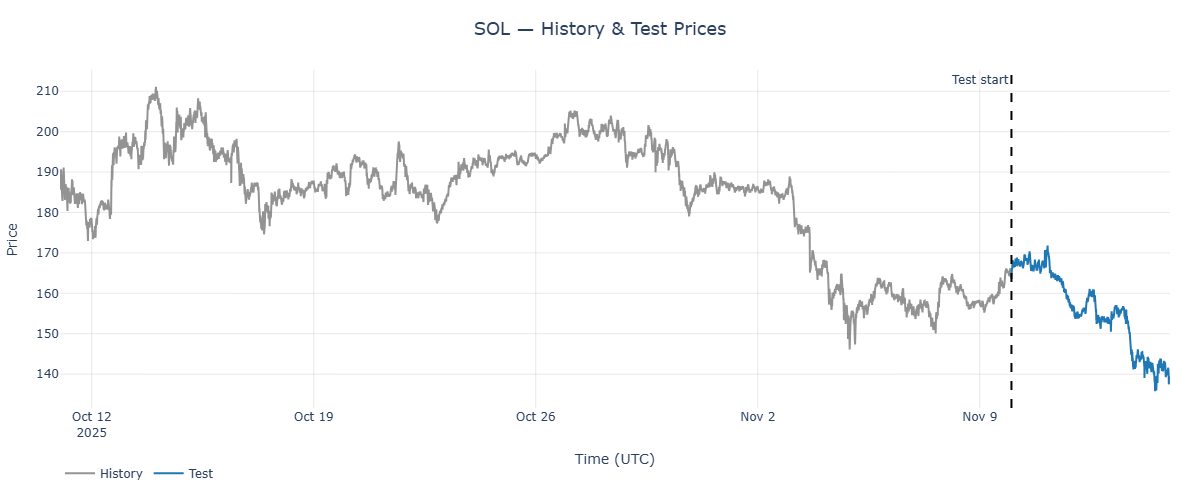

,asset,ts,price,split,time
0,BTC,1760140800,112725.082912,history,2025-10-11 00:00:00+00:00
1,BTC,1760140860,112640.608677,history,2025-10-11 00:01:00+00:00
2,BTC,1760140920,112518.000000,history,2025-10-11 00:02:00+00:00
3,BTC,1760140980,112899.083463,history,2025-10-11 00:03:00+00:00
4,BTC,1760141040,113015.138623,history,2025-10-11 00:04:00+00:00
...,...,...,...,...,...
100795,SOL,1763164500,138.768610,test,2025-11-14 23:55:00+00:00
100796,SOL,1763164560,138.620682,test,2025-11-14 23:56:00+00:00
100797,SOL,1763164620,138.604360,test,2025-11-14 23:57:00+00:00
100798,SOL,1763164680,138.554917,test,2025-11-14 23:58:00+00:00


In [6]:
visualize_price_data(
    history_data=initial_histories, test_data=test_asset_prices,
    selected_assets=None, show_graph=True
)

## Run live simulation on historic data

Evaluating BTC:   0%|          | 0/96 [00:00<?, ?eval/s]

[BTC] avg norm CRPS=21.0685 | recent=21.0685
[BTC] avg norm CRPS=20.7470 | recent=20.7470
[BTC] avg norm CRPS=20.9700 | recent=20.9700
[BTC] avg norm CRPS=22.6169 | recent=22.6169
[BTC] avg norm CRPS=24.8086 | recent=24.8086



Evaluating SOL:   0%|          | 0/96 [00:00<?, ?eval/s]

[SOL] avg norm CRPS=23.4471 | recent=23.4471
[SOL] avg norm CRPS=22.9034 | recent=22.9034
[SOL] avg norm CRPS=22.6201 | recent=22.6201
[SOL] avg norm CRPS=23.2194 | recent=23.2194
[SOL] avg norm CRPS=24.5254 | recent=24.5254


Tracker GaussianStepTracker:
Final average normalized crps score: 24.6670
[✔] Tracker results saved to results\2025-11-11T00-00-00_to_2025-11-14T23-00-00\GaussianStepTracker_h86400.json

(Note - Scores appear after quarantine: a score at time t evaluates a forecast issued at (t - horizon))


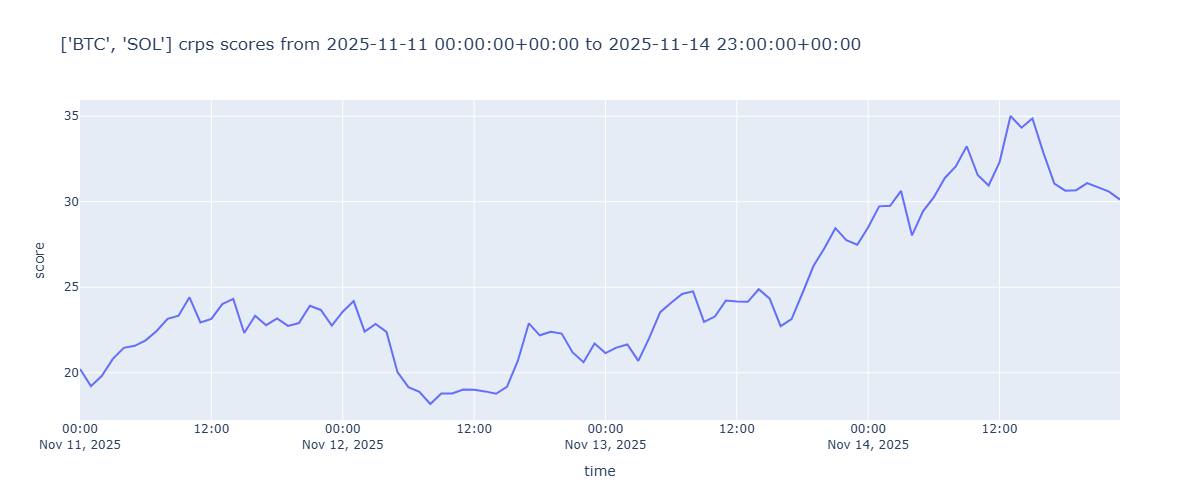

In [7]:
# Setup tracker + evaluator
tracker = GaussianStepTracker()
tracker_evaluator = TrackerEvaluator(tracker)

for asset, history_test_prices in test_asset_prices.items():

    # First tick: initialize the full historical data (prices before test prices)
    # This initializes the tracker state before evaluation begins.
    tracker_evaluator.tick({asset: initial_histories[asset]})

    prev_ts = 0
    predict_count = 0
    pbar = tqdm(desc=f"Evaluating {asset}", total=count_evaluations(history_test_prices, HORIZON, INTERVAL), unit="eval")

    for ts, price in history_test_prices:
        # Feed the new test price tick
        tracker_evaluator.tick({asset: [(ts, price)]})

        # Trigger a prediction round at the configured interval (ts is in second)
        if ts - prev_ts >= INTERVAL:
            prev_ts = ts
            predictions_evaluated = tracker_evaluator.predict(asset, HORIZON, STEPS)

            # Quarantine mechanism:
            # - Predictions are not scored immediately. Each prediction is placed in a quarantine 
            #   until sufficient future price data (up to the full horizon ticks) becomes available.
            # - Predictions issued within the final `horizon` seconds of the
            #   time series cannot be scored, as future observations are unavailable.

            if predictions_evaluated:
                pbar.update(1)

            # Periodically display results
            if predictions_evaluated and predict_count % 20 == 0:
                pbar.write(
                    f"[{asset}] avg norm CRPS={tracker_evaluator.overall_score_asset(asset):.4f} | "
                    f"recent={tracker_evaluator.recent_score_asset(asset):.4f}"
                )
            predict_count += 1
    
    # Final summary for this asset
    pbar.write(
            f"[{asset}] avg norm CRPS={tracker_evaluator.overall_score_asset(asset):.4f} | "
            f"recent={tracker_evaluator.recent_score_asset(asset):.4f}"
        )
    
    pbar.close()
    print()

# Global summary across all assets
tracker_name = tracker_evaluator.tracker.__class__.__name__
print(f"\nTracker {tracker_name}:"
      f"\nFinal average normalized crps score: {tracker_evaluator.overall_score():.4f}")

# Persist results to disk
current_results_dir = tracker_evaluator.to_json(horizon=HORIZON, steps=STEPS,
                                                interval=INTERVAL, base_dir=base_dir_results)

# Plot scoring timeline
timestamped_scores = tracker_evaluator.scores
print("\n(Note - Scores appear after quarantine: a score at time t evaluates a forecast issued at (t - horizon))")
plot_scores(timestamped_scores)

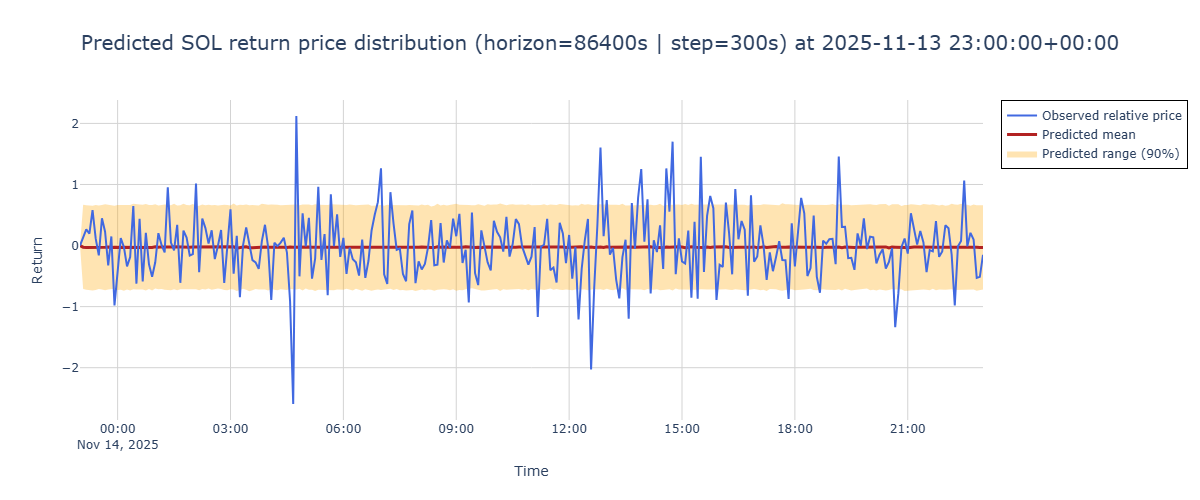

In [8]:
## Density forecast over returns (for the last asset and last prediction)
plot_quarantine(asset, predictions_evaluated[0], step=STEPS[0], prices=tracker_evaluator.tracker.prices, mode="direct")

Normalized CRPS score: 27.874270192947982


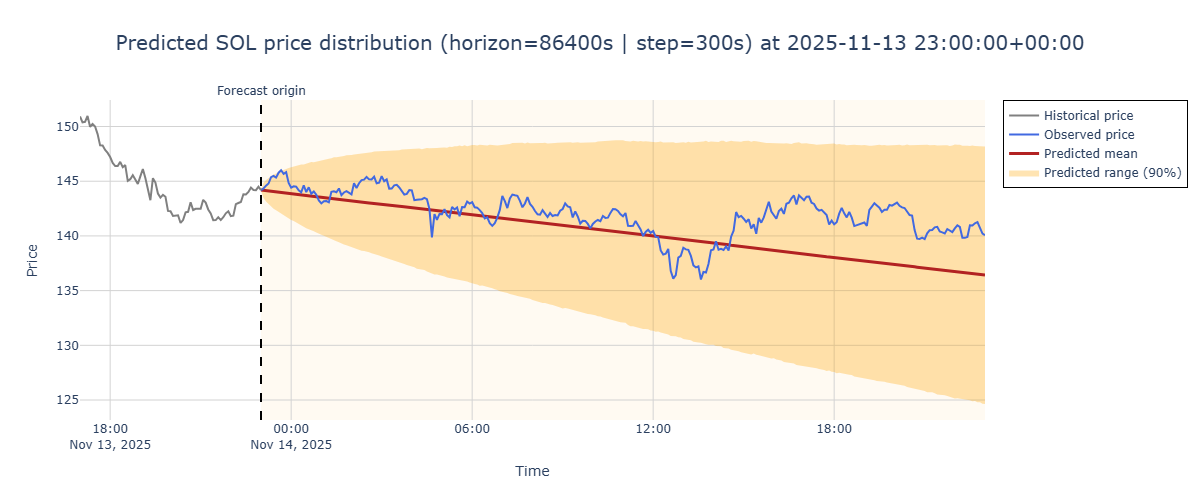

In [9]:
## Return forecast mapped into price space (for the last asset and last quarantine prediction)
print("Normalized CRPS score:", tracker_evaluator.scores[asset][-1][1])
plot_quarantine(asset, predictions_evaluated[0], step=STEPS[0], prices=tracker_evaluator.tracker.prices, mode="incremental", lookback_seconds=HORIZON/4)

# Tracker Comparison

In [10]:
from crunch_synth.utils.tracker_analysis import load_all_results, plot_tracker_comparison

In [11]:
df_all = load_all_results(current_results_dir, horizon=HORIZON)
df_all

Directory: results\2025-11-11T00-00-00_to_2025-11-14T23-00-00\*h86400.json
[✔] Found 2 files:
   - GaussianStepTracker_h86400.json
   - ShortGaussianTracker_h86400.json


,tracker,asset,horizon,ts,score,time
0,GaussianStepTracker,BTC,86400,1762819200,19.568227,2025-11-11 00:00:00+00:00
1,GaussianStepTracker,BTC,86400,1762822800,18.356777,2025-11-11 01:00:00+00:00
2,GaussianStepTracker,BTC,86400,1762826400,18.752766,2025-11-11 02:00:00+00:00
3,GaussianStepTracker,BTC,86400,1762830000,19.916111,2025-11-11 03:00:00+00:00
4,GaussianStepTracker,BTC,86400,1762833600,20.280920,2025-11-11 04:00:00+00:00
...,...,...,...,...,...,...
379,ShortGaussianTracker,SOL,86400,1763146800,32.225606,2025-11-14 19:00:00+00:00
380,ShortGaussianTracker,SOL,86400,1763150400,29.217213,2025-11-14 20:00:00+00:00
381,ShortGaussianTracker,SOL,86400,1763154000,29.126211,2025-11-14 21:00:00+00:00
382,ShortGaussianTracker,SOL,86400,1763157600,31.006759,2025-11-14 22:00:00+00:00


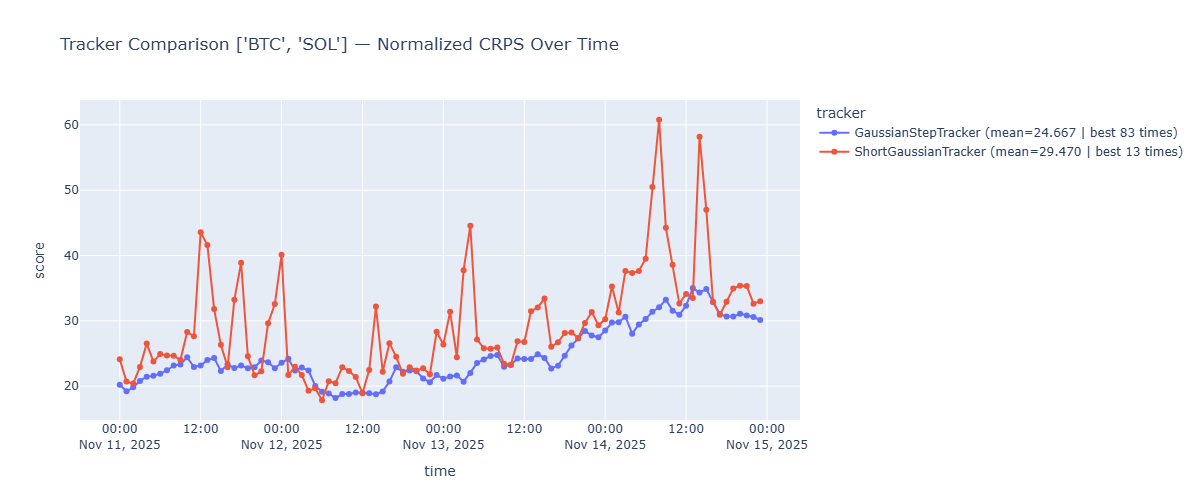

In [12]:
# Tracker comparison all assets (A lower CRPS score reflects more accurate predictions)
# Scores appear after quarantine: a score at time t evaluates a forecast issued at (t - horizon)
plot_tracker_comparison(df_all)

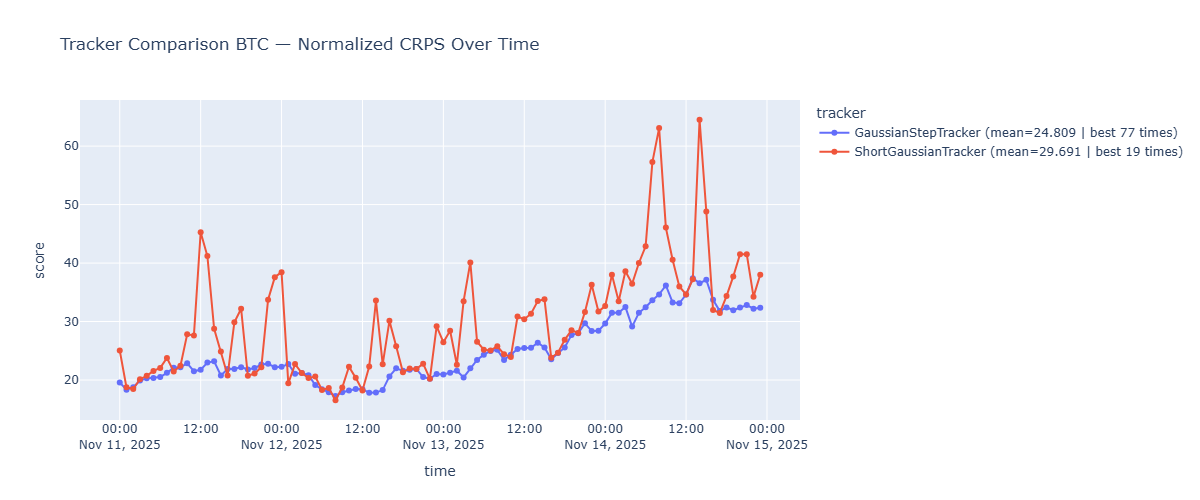

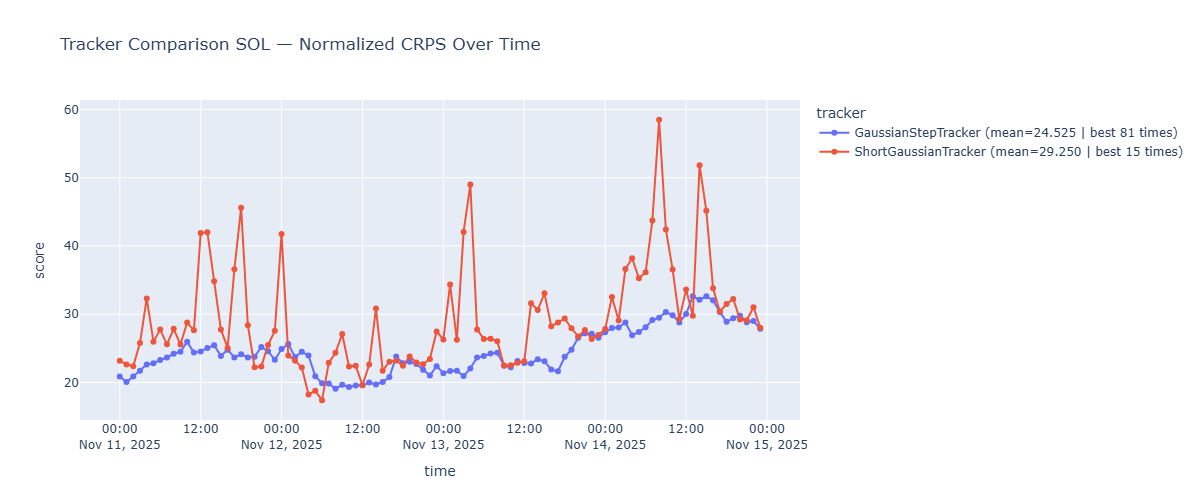

In [13]:
for asset in assets:
    plot_tracker_comparison(df_all, asset)

# Submit your Notebook

To submit your work, you must:
1. Download your Notebook from Colab
2. Upload it to the platform
3. Create a run to validate it

### >> https://hub.crunchdao.com/competitions/synth/submit/notebook

![Download and Submit Notebook](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/download-and-submit-notebook.gif)